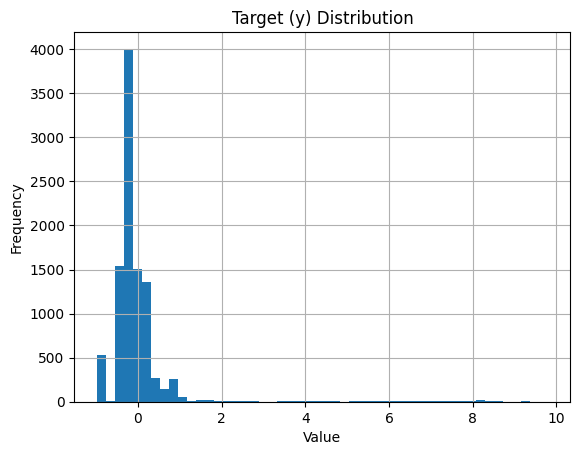

y std: 1.0011717


In [22]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from pathlib import Path

# 하이퍼파라미터 설정
window_size = 24
batch_size = 64
epochs = 50
learning_rate = 0.001
patience = 10
min_delta = 0.001  # 개선 기준: 이전보다 0.001 이상 좋아져야 인정
best_val_loss = float("inf")
patience_counter = 0

# .npy 파일에서 입력 시퀀스와 타깃 불러오기
X = np.load("../data/processed/X_lstm.npy").astype(np.float32)
y = np.load("../data/processed/y_lstm.npy").astype(np.float32)

# 데이터 분포 확인
plt.hist(y, bins=50)
plt.title("Target (y) Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
print("y std:", np.std(y))


In [23]:

# 학습/검증 데이터셋 분할 (80% 학습, 20% 검증)
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# PyTorch 텐서로 변환하고 DataLoader 구성
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    # def __init__(self, input_size=1, hidden_size=64, num_layers=1):
    # def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout=0.4): # 오버피팅
    def __init__(self, input_size=1, hidden_size=96, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout  # 마지막 layer 제외한 layer에만 적용됨
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 시점의 출력값 사용
        return out.view(-1)  # 안정적인 출력
        # return out.squeeze()

# 모델, 손실 함수, 최적화 도구 정의
model = LSTMModel()
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


# 학습 손실 및 검증 손실 저장 리스트
train_losses, val_losses = [], []
best_model_path = "models/lstm_best.pth"

# 학습 반복
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.unsqueeze(-1)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    # 평균 손실 계산
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 학습 상태 출력
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f} - Val Loss: {val_loss:.5f}")

    # 중간 예측 확인 (5 에폭마다)
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            sample_input = torch.from_numpy(X_val[:1]).unsqueeze(-1)
            sample_pred = model(sample_input).numpy()
            print(f"Sample prediction at epoch {epoch+1}: {sample_pred}")
    # Early stopping 체크
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# 모델 저장
Path("models").mkdir(exist_ok=True)
torch.save(model.state_dict(), "models/lstm_model.pth")
print("Model saved to models/lstm_model.pth")
print(f"Best model saved to {best_model_path}")


Epoch 1/50 - Train Loss: 0.01034 - Val Loss: 0.50581
Epoch 2/50 - Train Loss: 0.00578 - Val Loss: 0.47658
Epoch 3/50 - Train Loss: 0.00538 - Val Loss: 0.45812
Epoch 4/50 - Train Loss: 0.00524 - Val Loss: 0.43016
Epoch 5/50 - Train Loss: 0.00509 - Val Loss: 0.40924
Sample prediction at epoch 5: [-0.14113033]
Epoch 6/50 - Train Loss: 0.00476 - Val Loss: 0.36907
Epoch 7/50 - Train Loss: 0.00458 - Val Loss: 0.33844
Epoch 8/50 - Train Loss: 0.00459 - Val Loss: 0.33697
Epoch 9/50 - Train Loss: 0.00441 - Val Loss: 0.33633
Epoch 10/50 - Train Loss: 0.00436 - Val Loss: 0.37561
Sample prediction at epoch 10: [-0.1016385]
Epoch 11/50 - Train Loss: 0.00442 - Val Loss: 0.29423
Epoch 12/50 - Train Loss: 0.00428 - Val Loss: 0.35415
Epoch 13/50 - Train Loss: 0.00419 - Val Loss: 0.34969
Epoch 14/50 - Train Loss: 0.00428 - Val Loss: 0.30495
Epoch 15/50 - Train Loss: 0.00427 - Val Loss: 0.29356
Sample prediction at epoch 15: [-0.14325006]
Epoch 16/50 - Train Loss: 0.00427 - Val Loss: 0.35130
Epoch 17/50 

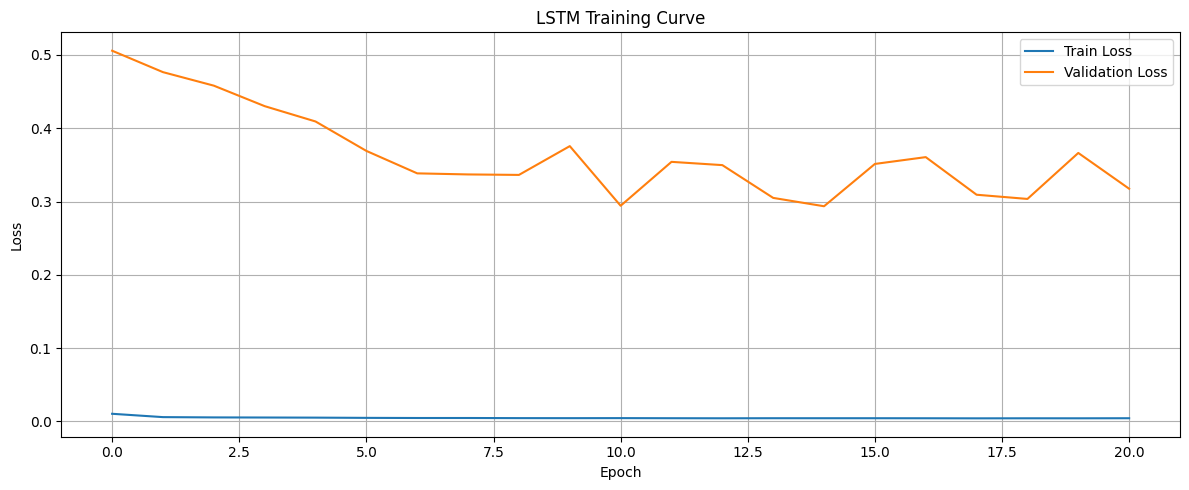

In [24]:

# 손실 시각화
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("LSTM Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()